# Yelp Review Rating Prediction

Author: Zefang Liu

Github: https://github.com/zefang-liu

## Introduction

In this project, we will predict ratings for Yelp reviews. Google Colab is used here with GPU and High-RAM.

## Data

We will use [Yelp Open Dataset](https://www.yelp.com/dataset). The datasets should be in `Yelp/yelp_dataset` folder.

### Data Preparation

We need to import several packages first.

In [ ]:
%cd /content/drive/MyDrive/Yelp

/content/drive/MyDrive/Yelp


In [ ]:
import sys, os, re, json
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from collections import defaultdict, Counter
from typing import List, Tuple, Dict

In [ ]:
%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Here are some file paths.

In [ ]:
dir_dataset = "yelp_dataset"
file_business = os.path.join(dir_dataset, "yelp_academic_dataset_business.json")
file_review = os.path.join(dir_dataset, "yelp_academic_dataset_review.json")

We will only use the reviews for restaurants.

In [ ]:
def get_restaurants(file_business):
  with open(file_business, 'r') as file:
    restaurants = set()

    for json_str in file:
      obj = json.loads(json_str)
      if obj["business_id"] and obj["categories"] \
      and "restaurants" in obj["categories"].lower():
        restaurants.add(obj["business_id"])

    return restaurants

In [ ]:
%time restaurants = get_restaurants(file_business)

CPU times: user 2.62 s, sys: 92 ms, total: 2.71 s
Wall time: 3.06 s


In [ ]:
print("Number of restaurants:", len(restaurants))

Number of restaurants: 63944


In [ ]:
def get_reviews(file_review):
  with open(file_review, 'r') as file:
    text_list = []
    stars_list = []

    for index, json_str in enumerate(file):
      obj = json.loads(json_str)
      if obj["business_id"] and obj["business_id"] in restaurants:
        if obj["text"] and obj["stars"]:
          text_list.append(obj["text"])
          stars_list.append(int(obj["stars"]))

    df = pd.DataFrame.from_dict({"text": text_list, "stars": stars_list})
    return df

In [ ]:
%time df_review = get_reviews(file_review)

CPU times: user 1min 7s, sys: 8.1 s, total: 1min 15s
Wall time: 1min 23s


In [ ]:
df_review.shape

(5055992, 2)

Some samples for reviews.

In [ ]:
df_review.head(10)

,text,stars
0,I love Deagan's. I do. I really do. The atmosp...,5
1,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",1
2,"Oh happy day, finally have a Canes near my cas...",4
3,This is definitely my favorite fast food sub s...,5
4,"Really good place with simple decor, amazing f...",5
5,Most delicious authentic Italian I've had in t...,5
6,I have been here twice. Very nice and laid bac...,4
7,ORDER In (Delivery) Review\n\nI discovered thi...,4
8,Everything that my husband and I tried today w...,5
9,10pm on a super bowl Sunday and they're alread...,1


### Data Distribution

We should rating distribution here.

In [ ]:
df_review["stars"].value_counts(normalize=False)

5    2077511
4    1254099
3     639748
1     628044
2     456590
Name: stars, dtype: int64

In [ ]:
def plot_labels(df, title=None):
  ds_labels = df["stars"].value_counts(normalize=True)
  ds_labels.sort_index(inplace=True)
  plt.figure(figsize=(4,3))
  ax = ds_labels.plot(kind="bar")
  ax.set_xlabel("Stars")
  ax.set_ylabel("Ratio")
  if title is not None:
    plt.savefig(title + ".eps")
  plt.show()

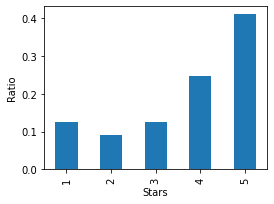

In [ ]:
plot_labels(df_review, "stars")

We can find that the dataset is imbalanced.

### Data Preprocessing and Split

We need to seperate training, validation, and testing sets.

* Training set: balanced dataset
* Validation/Testing set: raw (imbalanced) dataset

In [ ]:
from sklearn.model_selection import train_test_split

df_train_raw, df_test = train_test_split(df_review, test_size=250000, 
                                         random_state=42, shuffle=True)
df_train_raw, df_dev = train_test_split(df_train_raw, test_size=250000,
                                        random_state=42, shuffle=True)

In [ ]:
df_train_raw["stars"].value_counts(normalize=False)

5    1871889
4    1129897
3     577351
1     565751
2     411104
Name: stars, dtype: int64

In [ ]:
from sklearn.utils import resample

def undersample(df, group_size=250000):
  dfs = []

  for label in df["stars"].value_counts().keys():
    df_group = df[df["stars"] == label]
    df_group_undersampled = resample(df_group, 
                                     replace=False, 
                                     n_samples=group_size, 
                                     random_state=0)
    dfs.append(df_group_undersampled)

  return pd.concat(dfs).sample(frac=1, random_state=0)

In [ ]:
df_train = undersample(df_train_raw)

In [ ]:
num_review = df_review.shape[0]
num_train = df_train.shape[0]
num_dev = df_dev.shape[0]
num_test = df_test.shape[0]

(1250000, 2)


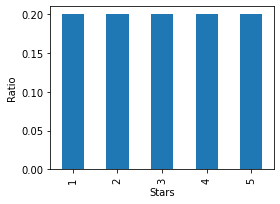

In [ ]:
print(df_train.shape)
plot_labels(df_train)

(250000, 2)


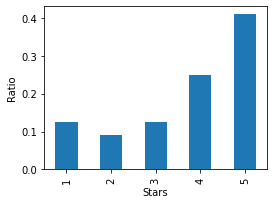

In [ ]:
print(df_dev.shape)
plot_labels(df_dev)

(250000, 2)


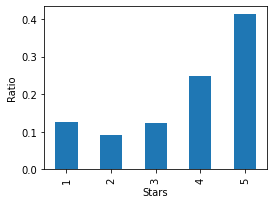

In [ ]:
print(df_test.shape)
plot_labels(df_test)

In [ ]:
df_train["labels"] = df_train["stars"] - 1
df_dev["labels"] = df_dev["stars"] - 1
df_test["labels"] = df_test["stars"] - 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_train.head(10)

,text,stars,labels
3830956,Food alright needs up grades on everything els...,1,0
64799,My wife and I went here expecting good things....,1,0
2183939,Went to Lili.co on a Saturday night with two f...,4,3
346349,I went to Sorocco for my bday. We were around ...,5,4
983213,Slowest panera ever. With rude and impatient s...,2,1
3844806,Step one: Located Tix4Tonight. Buy buffet pas...,3,2
57590,"Coffee and food was good, although I would not...",2,1
14794,My wife and I are from Rockford Ill and this p...,5,4
2349281,So my friends and I came through the drive thr...,3,2
3171814,New fave place - made reservations weeks ago f...,5,4


## Feature Engineering

### Tokenization

In this part, we will tokenize reviews and count numbers of tokens for each review. This information will be useful in BERT model. But we will not use these tokens directly for training models.

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
ds_temp = df_train["text"].iloc[:10].map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).map(lambda text: text.split())
print(df_train["text"].iloc[0], '\n', ds_temp.iloc[0])

Such a great restaurant but what's most amazing was the service! Mike and Easton are literally the best.... Extremely professional and very accommodating! We dined here on two separate occasions while family was visiting and both times were awesome experiences thanks to these guys! Mike wasn't even our waiter the second visit but he still took care of us... As fellow Californians it was much appreciated. We'll definitely be back! 
 ['Such', 'a', 'great', 'restaurant', 'but', "what's", 'most', 'amazing', 'was', 'the', 'service', 'Mike', 'and', 'Easton', 'are', 'literally', 'the', 'best', 'Extremely', 'professional', 'and', 'very', 'accommodating', 'We', 'dined', 'here', 'on', 'two', 'separate', 'occasions', 'while', 'family', 'was', 'visiting', 'and', 'both', 'times', 'were', 'awesome', 'experiences', 'thanks', 'to', 'these', 'guys', 'Mike', "wasn't", 'even', 'our', 'waiter', 'the', 'second', 'visit', 'but', 'he', 'still', 'took', 'care', 'of', 'us', 'As', 'fellow', 'Californians', 'it'

In [ ]:
%time df_train["tokens"] = df_train["text"].map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).map(lambda text: text.split())

CPU times: user 33.1 s, sys: 5.16 s, total: 38.3 s
Wall time: 38.3 s


In [ ]:
df_train["num_tokens"] = df_train["tokens"].map(len)
ax = df_train["num_tokens"].hist(bins=20, 
                                 figsize=(4,3),
                                 weights=np.ones(num_train)/num_train)
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Ratio")
plt.show()

In [ ]:
print(len(df_train[df_train["num_tokens"] <= 128]) / len(df_train["num_tokens"]))
print(len(df_train[df_train["num_tokens"] <= 256]) / len(df_train["num_tokens"]))

0.6874416
0.9113776


In [ ]:
df_train.drop(columns=["tokens", "num_tokens"], inplace=True)

In [ ]:
%time df_review["num_tokens"] = df_review["text"].\
map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).\
map(lambda text: len(text.split()))

CPU times: user 1min 22s, sys: 1.16 s, total: 1min 23s
Wall time: 1min 23s


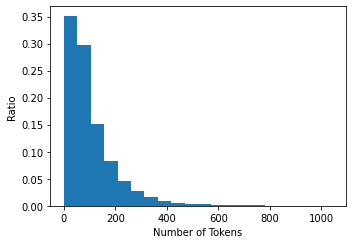

In [ ]:
ax = df_review["num_tokens"].hist(bins=20,
                                  figsize=(5,3.5),
                                  grid=False,
                                  weights=np.ones(num_review)/num_review)
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Ratio")
plt.savefig("num_tokens.eps")
plt.tight_layout()
plt.show()

In [ ]:
print(len(df_review[df_review["num_tokens"] <= 128]) / len(df_review["num_tokens"]))
print(len(df_review[df_review["num_tokens"] <= 256]) / len(df_review["num_tokens"]))

0.7309105710610302
0.92764842191206


In [ ]:
df_review.drop(columns=[num_tokens"], inplace=True)

From the result, we can see most reviews are shorter than 256 tokens.

### Vectorization

We will try following settings for vectorization.

* Word representation: `CountVectorizer` vs. `TfidfVectorizer`
* N-grams: unigram & bigram
* Minimum document frequency: 5
* Convert to lowercase
* Use stop words
* Try binary counter

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def extract_features(df_train, df_dev, df_test):
  vectorizer = TfidfVectorizer(analyzer='word', 
                               stop_words='english',
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
  X_train = vectorizer.fit_transform(df_train["text"])
  X_dev = vectorizer.transform(df_dev["text"])
  X_test = vectorizer.transform(df_test["text"])
  y_train = df_train["stars"].tolist()
  y_dev = df_dev["stars"].tolist()
  y_test = df_test["stars"].tolist()
  
  return X_train, X_dev, X_test, y_train, y_dev, y_test

In [ ]:
%time X_train, X_dev, X_test, y_train, y_dev, y_test = extract_features(df_train, df_dev, df_test)

CPU times: user 6min 1s, sys: 4.42 s, total: 6min 6s
Wall time: 6min 6s


#### Test for CountVectorizer (Binary)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [ ]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 11.7min finished


LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

Training Set
Accuracy: 0.7382096

              precision    recall  f1-score   support

           1     0.7989    0.8411    0.8195    250000
           2     0.7288    0.6754    0.7010    250000
           3     0.6736    0.7156    0.6939    250000
           4     0.7426    0.6012    0.6644    250000
           5     0.7469    0.8579    0.7985    250000

    accuracy                         0.7382   1250000
   macro avg     0.7381    0.7382    0.7355   1250000
weighted avg     0.7381    0.7382    0.7355   1250000



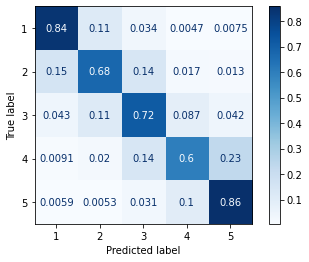


Validation Set
Accuracy: 0.628484

              precision    recall  f1-score   support

           1     0.7267    0.7436    0.7350     31118
           2     0.4263    0.4840    0.4533     22851
           3     0.4144    0.5373    0.4679     31401
           4     0.5343    0.4332    0.4785     62178
           5     0.7826    0.7722    0.7774    102452

    accuracy                         0.6285    250000
   macro avg     0.5769    0.5941    0.5824    250000
weighted avg     0.6351    0.6285    0.6293    250000



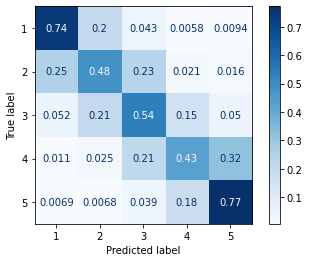


Testing Set
Accuracy: 0.630324

              precision    recall  f1-score   support

           1     0.7296    0.7450    0.7372     31175
           2     0.4274    0.4824    0.4533     22635
           3     0.4112    0.5431    0.4681     30996
           4     0.5335    0.4349    0.4791     62024
           5     0.7875    0.7718    0.7796    103170

    accuracy                         0.6303    250000
   macro avg     0.5778    0.5954    0.5834    250000
weighted avg     0.6380    0.6303    0.6316    250000



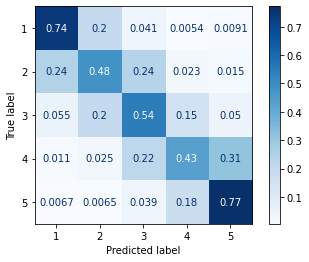

In [ ]:
evaluate_model(clf_lr, model_name="lr", model_name="lr_count_bin")

#### Test for CountVectorizer (Integer)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [ ]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 15.7min finished


LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

Training Set
Accuracy: 0.701736

              precision    recall  f1-score   support

           1     0.7698    0.8192    0.7937    250000
           2     0.6740    0.6328    0.6527    250000
           3     0.6607    0.6170    0.6381    250000
           4     0.6393    0.6496    0.6444    250000
           5     0.7547    0.7901    0.7720    250000

    accuracy                         0.7017   1250000
   macro avg     0.6997    0.7017    0.7002   1250000
weighted avg     0.6997    0.7017    0.7002   1250000



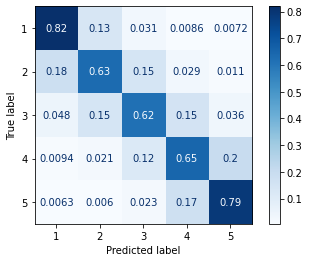


Validation Set
Accuracy: 0.632088

              precision    recall  f1-score   support

           1     0.7264    0.7511    0.7386     31118
           2     0.4358    0.5014    0.4663     22851
           3     0.4543    0.4961    0.4743     31401
           4     0.5149    0.5334    0.5240     62178
           5     0.8020    0.7266    0.7624    102452

    accuracy                         0.6321    250000
   macro avg     0.5867    0.6017    0.5931    250000
weighted avg     0.6440    0.6321    0.6369    250000



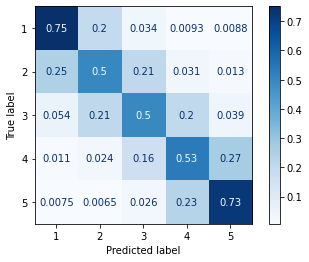


Testing Set
Accuracy: 0.632736

              precision    recall  f1-score   support

           1     0.7290    0.7534    0.7410     31175
           2     0.4332    0.4935    0.4614     22635
           3     0.4448    0.4945    0.4683     30996
           4     0.5134    0.5332    0.5231     62024
           5     0.8068    0.7282    0.7655    103170

    accuracy                         0.6327    250000
   macro avg     0.5854    0.6006    0.5919    250000
weighted avg     0.6456    0.6327    0.6379    250000



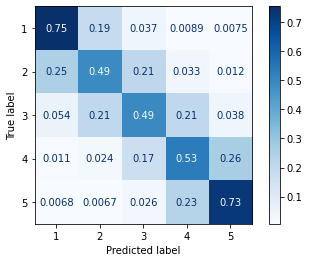

In [ ]:
evaluate_model(clf_lr, model_name="lr_count_int")

#### Test for TfidfVectorizer (Binary)

In [ ]:
X_train[:10,:]

<10x1575256 sparse matrix of type '<class 'numpy.float64'>'
	with 918 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [ ]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 14.5min finished


LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

Training Set
Accuracy: 0.6574464

              precision    recall  f1-score   support

           1     0.7475    0.7750    0.7610    250000
           2     0.5984    0.5827    0.5905    250000
           3     0.5948    0.5759    0.5852    250000
           4     0.5979    0.5970    0.5975    250000
           5     0.7398    0.7565    0.7480    250000

    accuracy                         0.6574   1250000
   macro avg     0.6557    0.6574    0.6564   1250000
weighted avg     0.6557    0.6574    0.6564   1250000



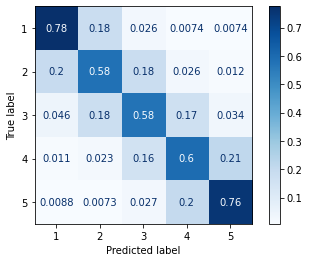


Validation Set
Accuracy: 0.63576

              precision    recall  f1-score   support

           1     0.7366    0.7436    0.7401     31118
           2     0.4375    0.5265    0.4778     22851
           3     0.4537    0.5208    0.4849     31401
           4     0.5214    0.5384    0.5298     62178
           5     0.8140    0.7217    0.7651    102452

    accuracy                         0.6358    250000
   macro avg     0.5926    0.6102    0.5995    250000
weighted avg     0.6519    0.6358    0.6420    250000



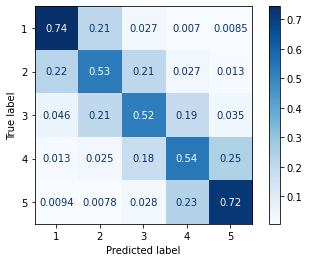


Testing Set
Accuracy: 0.636472

              precision    recall  f1-score   support

           1     0.7397    0.7443    0.7420     31175
           2     0.4366    0.5221    0.4755     22635
           3     0.4498    0.5267    0.4853     30996
           4     0.5203    0.5386    0.5293     62024
           5     0.8166    0.7208    0.7657    103170

    accuracy                         0.6365    250000
   macro avg     0.5926    0.6105    0.5996    250000
weighted avg     0.6536    0.6365    0.6431    250000



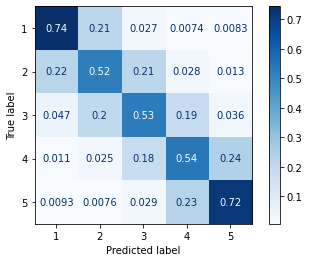

In [ ]:
evaluate_model(clf_lr, model_name="lr_tfidf_bin")

#### Test for TfidfVectorizer (Integer)

In [ ]:
X_train[:10,:]

<10x1575256 sparse matrix of type '<class 'numpy.float64'>'
	with 918 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [ ]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 13.9min finished


LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

Training Set
Accuracy: 0.6516936

              precision    recall  f1-score   support

           1     0.7432    0.7732    0.7579    250000
           2     0.5870    0.5845    0.5858    250000
           3     0.5833    0.5615    0.5722    250000
           4     0.6064    0.5616    0.5832    250000
           5     0.7233    0.7777    0.7495    250000

    accuracy                         0.6517   1250000
   macro avg     0.6486    0.6517    0.6497   1250000
weighted avg     0.6486    0.6517    0.6497   1250000



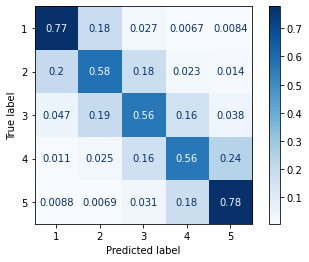


Validation Set
Accuracy: 0.63872

              precision    recall  f1-score   support

           1     0.7338    0.7476    0.7406     31118
           2     0.4350    0.5352    0.4799     22851
           3     0.4458    0.5142    0.4776     31401
           4     0.5354    0.5080    0.5213     62178
           5     0.8050    0.7462    0.7745    102452

    accuracy                         0.6387    250000
   macro avg     0.5910    0.6102    0.5988    250000
weighted avg     0.6502    0.6387    0.6431    250000



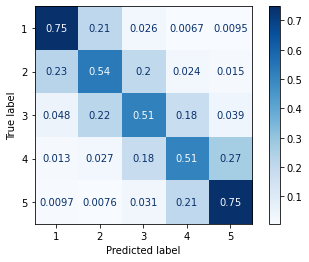


Testing Set
Accuracy: 0.640664

              precision    recall  f1-score   support

           1     0.7380    0.7481    0.7430     31175
           2     0.4367    0.5330    0.4801     22635
           3     0.4431    0.5195    0.4783     30996
           4     0.5349    0.5111    0.5227     62024
           5     0.8088    0.7461    0.7762    103170

    accuracy                         0.6407    250000
   macro avg     0.5923    0.6116    0.6001    250000
weighted avg     0.6530    0.6407    0.6454    250000



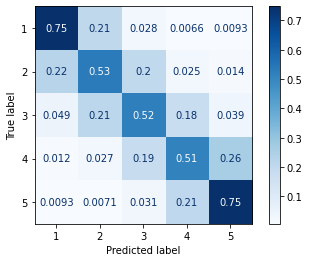

In [ ]:
evaluate_model(clf_lr, model_name="lr_tfidf_int")

## Experiments and Results

We will use machine learning models and transformer-based models.

### Machine Learning

Navie Bayes, Logistic Regression, Random Forest, and Linear SVM will used in this section.

#### Evaluation Metrics

* Precision, recall, F1 score
* Accuracy
* Confusion matrix

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [ ]:
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
  if y_pred is None:
    y_pred = model.predict(X)

  print(label + ' Set')
  print("Accuracy:", accuracy_score(y, y_pred))
  print()

  print(classification_report(y, y_pred, digits=4))
  disp = plot_confusion_matrix(model, X, y, 
                               cmap=plt.cm.Blues, normalize='true')
  plt.savefig(model_name + "_" + label.lower() + ".eps")
  plt.show()
  print()

In [ ]:
def evaluate_model(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
  evaluate_model_Xy(model, X_train, y_train, label="Training", model_name=model_name)
  evaluate_model_Xy(model, X_dev, y_dev, label="Validation", model_name=model_name)
  evaluate_model_Xy(model, X_test, y_test, label="Testing", model_name=model_name)

#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB(alpha=0.5,
                       fit_prior=True)

In [ ]:
%time clf_nb.fit(X_train, y_train)

CPU times: user 4.56 s, sys: 5.78 ms, total: 4.56 s
Wall time: 4.56 s


MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

Training Set
Accuracy: 0.7388216

              precision    recall  f1-score   support

           1     0.7256    0.8041    0.7629    250000
           2     0.6909    0.6448    0.6671    250000
           3     0.7260    0.6835    0.7041    250000
           4     0.7308    0.7361    0.7334    250000
           5     0.8175    0.8256    0.8215    250000

    accuracy                         0.7388   1250000
   macro avg     0.7382    0.7388    0.7378   1250000
weighted avg     0.7382    0.7388    0.7378   1250000



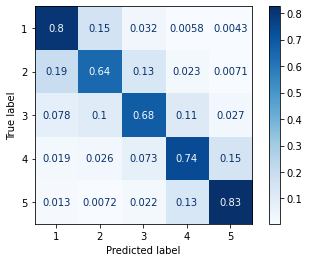


Validation Set
Accuracy: 0.612748

              precision    recall  f1-score   support

           1     0.6579    0.7224    0.6886     31118
           2     0.3882    0.4538    0.4185     22851
           3     0.4345    0.4812    0.4566     31401
           4     0.5059    0.5397    0.5223     62178
           5     0.8143    0.6996    0.7526    102452

    accuracy                         0.6127    250000
   macro avg     0.5602    0.5793    0.5677    250000
weighted avg     0.6315    0.6127    0.6196    250000



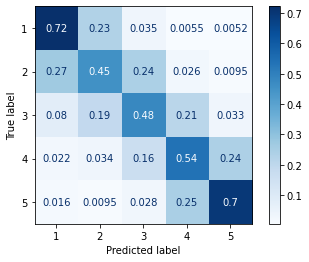


Testing Set
Accuracy: 0.615004

              precision    recall  f1-score   support

           1     0.6605    0.7203    0.6891     31175
           2     0.3940    0.4624    0.4255     22635
           3     0.4332    0.4872    0.4586     30996
           4     0.5058    0.5404    0.5225     62024
           5     0.8177    0.6999    0.7543    103170

    accuracy                         0.6150    250000
   macro avg     0.5622    0.5820    0.5700    250000
weighted avg     0.6347    0.6150    0.6222    250000



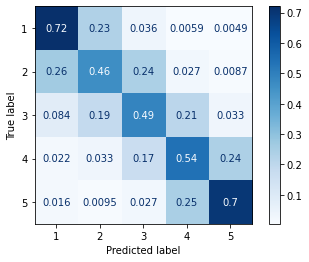

In [ ]:
evaluate_model(clf_nb, model_name="nb")

In [ ]:
del clf_nb

#### Logisitc Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [ ]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 12.7min finished


LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

Training Set
Accuracy: 0.6516936

              precision    recall  f1-score   support

           1     0.7432    0.7732    0.7579    250000
           2     0.5870    0.5845    0.5858    250000
           3     0.5833    0.5615    0.5722    250000
           4     0.6064    0.5616    0.5832    250000
           5     0.7233    0.7777    0.7495    250000

    accuracy                         0.6517   1250000
   macro avg     0.6486    0.6517    0.6497   1250000
weighted avg     0.6486    0.6517    0.6497   1250000



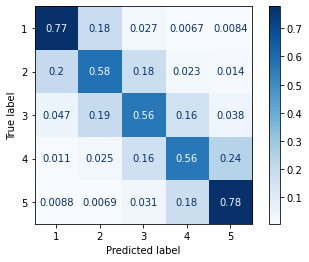


Validation Set
Accuracy: 0.63872

              precision    recall  f1-score   support

           1     0.7338    0.7476    0.7406     31118
           2     0.4350    0.5352    0.4799     22851
           3     0.4458    0.5142    0.4776     31401
           4     0.5354    0.5080    0.5213     62178
           5     0.8050    0.7462    0.7745    102452

    accuracy                         0.6387    250000
   macro avg     0.5910    0.6102    0.5988    250000
weighted avg     0.6502    0.6387    0.6431    250000



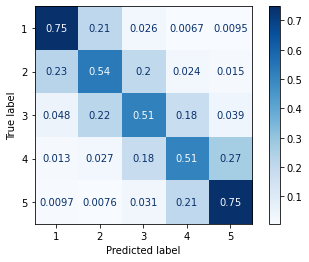


Testing Set
Accuracy: 0.640664

              precision    recall  f1-score   support

           1     0.7380    0.7481    0.7430     31175
           2     0.4367    0.5330    0.4801     22635
           3     0.4431    0.5195    0.4783     30996
           4     0.5349    0.5111    0.5227     62024
           5     0.8088    0.7461    0.7762    103170

    accuracy                         0.6407    250000
   macro avg     0.5923    0.6116    0.6001    250000
weighted avg     0.6530    0.6407    0.6454    250000



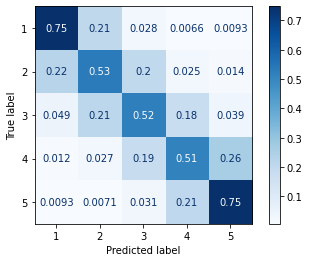

In [ ]:
evaluate_model(clf_lr, model_name="lr")

In [ ]:
del clf_lr

#### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None, 
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features="auto", 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

In [ ]:
clf_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 52.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 58.7min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   58.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 10.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed: 11.3min finished


Training Set
Accuracy: 0.5911504

              precision    recall  f1-score   support

           1     0.6026    0.8394    0.7016    250000
           2     0.5948    0.4250    0.4958    250000
           3     0.5879    0.4750    0.5255    250000
           4     0.5686    0.4394    0.4957    250000
           5     0.5922    0.7769    0.6721    250000

    accuracy                         0.5912   1250000
   macro avg     0.5892    0.5912    0.5781   1250000
weighted avg     0.5892    0.5912    0.5781   1250000



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   59.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 10.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed: 11.3min finished


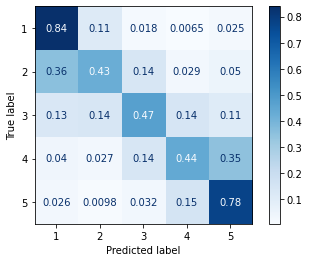

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   49.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.1min finished


Validation Set
Accuracy: 0.594076

              precision    recall  f1-score   support

           1     0.5825    0.8222    0.6819     31118
           2     0.4049    0.3659    0.3845     22851
           3     0.4126    0.4161    0.4144     31401
           4     0.5030    0.3844    0.4358     62178
           5     0.7304    0.7575    0.7437    102452

    accuracy                         0.5941    250000
   macro avg     0.5267    0.5492    0.5320    250000
weighted avg     0.5858    0.5941    0.5852    250000



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished


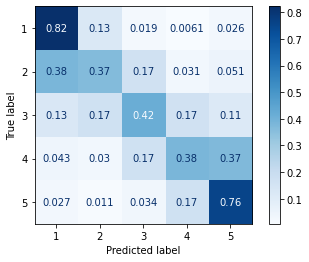

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   49.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.1min finished


Testing Set
Accuracy: 0.595396

              precision    recall  f1-score   support

           1     0.5822    0.8195    0.6808     31175
           2     0.4083    0.3701    0.3883     22635
           3     0.4100    0.4192    0.4145     30996
           4     0.5025    0.3851    0.4360     62024
           5     0.7336    0.7565    0.7449    103170

    accuracy                         0.5954    250000
   macro avg     0.5273    0.5501    0.5329    250000
weighted avg     0.5878    0.5954    0.5870    250000



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished


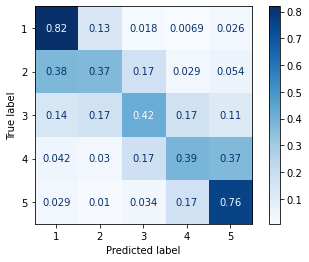

In [ ]:
evaluate_model(clf_rf, model_name="rf")

In [ ]:
del clf_rf

#### Linear Support Vector Machine (SVM)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf_sgd = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge',
                                      penalty='l2',
                                      alpha=30,
                                      max_iter=1000, 
                                      tol=1e-3,
                                      shuffle=True,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0,
                                      learning_rate='optimal',
                                      early_stopping=True,
                                      class_weight='balanced'))

In [ ]:
clf_sgd.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1-- Epoch 1

Norm: 0.11, NNZs: 1558816, Bias: 0.001876, T: 1125000, Avg. loss: 0.441736
Total training time: 3.38 seconds.
Norm: 0.10, NNZs: 1560513, Bias: -0.006005, T: 1125000, Avg. loss: 0.494029
Total training time: 3.40 seconds.
Norm: 0.10, NNZs: 1567854, Bias: -0.006388, T: 1125000, Avg. loss: 0.502971
Total training time: 3.43 seconds.
Norm: 0.10, NNZs: 1567719, Bias: 0.002135, T: 1125000, Avg. loss: 0.510538
Total training time: 3.48 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 0.10, NNZs: 1569715, Bias: -0.006490, T: 2250000, Avg. loss: 0.480062
Total training time: 7.35 seconds.
Norm: 0.11, NNZs: 1562306, Bias: 0.001781, T: 2250000, Avg. loss: 0.420601
Total training time: 7.36 seconds.
Norm: 0.10, NNZs: 1563590, Bias: -0.006102, T: 2250000, Avg. loss: 0.472608
Total training time: 7.37 seconds.
Norm: 0.10, NNZs: 1569464, Bias: 0.002032, T: 2250000, Avg. loss: 0.487301
Total training time: 7.37 seconds.
-- Epoch 3
-- Epoch 3
-- Epo

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.4s finished


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('sgdclassifier',
                 SGDClassifier(alpha=30, average=False, class_weight='balanced',
                               early_stopping=True, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=-1,
                               penalty='l2', power_t=0.5, random_state=0,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=1, warm_start=False))],
         verbose=False)

Training Set
Accuracy: 0.7624648

              precision    recall  f1-score   support

           1     0.6548    0.9362    0.7706    250000
           2     0.8450    0.5932    0.6970    250000
           3     0.8517    0.6629    0.7455    250000
           4     0.8214    0.6903    0.7502    250000
           5     0.7440    0.9298    0.8266    250000

    accuracy                         0.7625   1250000
   macro avg     0.7834    0.7625    0.7580   1250000
weighted avg     0.7834    0.7625    0.7580   1250000



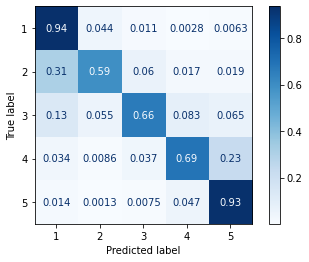


Validation Set
Accuracy: 0.617348

              precision    recall  f1-score   support

           1     0.5529    0.8608    0.6733     31118
           2     0.4274    0.3141    0.3621     22851
           3     0.4665    0.3606    0.4068     31401
           4     0.5374    0.4072    0.4634     62178
           5     0.7385    0.8173    0.7759    102452

    accuracy                         0.6173    250000
   macro avg     0.5446    0.5520    0.5363    250000
weighted avg     0.6028    0.6173    0.6012    250000



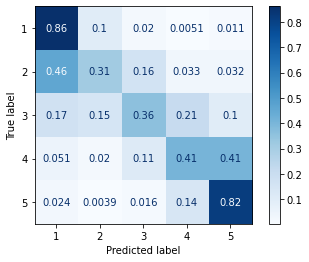


Testing Set
Accuracy: 0.61988

              precision    recall  f1-score   support

           1     0.5551    0.8588    0.6744     31175
           2     0.4317    0.3186    0.3666     22635
           3     0.4632    0.3630    0.4071     30996
           4     0.5385    0.4103    0.4658     62024
           5     0.7424    0.8169    0.7779    103170

    accuracy                         0.6199    250000
   macro avg     0.5462    0.5535    0.5383    250000
weighted avg     0.6058    0.6199    0.6043    250000



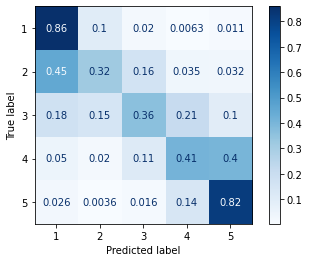

In [ ]:
evaluate_model(clf_sgd, model_name="sgd")

10: 0.611916

20: 0.616532

30: 0.617348

35: 0.617388

40: 0.616676

In [ ]:
del clf_sgd

### Deep Learning

Transformer-based models including BERT, DistilBERT, RoBERTa, and XLNet will be used in this section.

#### Packages

The Python package `simpletransformers` will be used.

In [ ]:
%pip install simpletransformers
from simpletransformers.classification import ClassificationModel

#### Evaluation Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [ ]:
def evaluate_bert_model_one(model, df, label="Training", model_name="model"):
  y = df['labels'].tolist()
  y_pred, raw_outputs = model.predict(df['text'].tolist())

  print(label + ' Set')
  print("Accuracy:", accuracy_score(y, y_pred))
  print()

  print(classification_report(y, y_pred, digits=4))
  df_cm = pd.DataFrame(confusion_matrix(y, y_pred, normalize='true'), 
                       range(1,6), range(1,6))
  plt.figure(figsize=(6,4))
  ax = sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, square=True)
  ax.set_xlabel('Predicted label')
  ax.set_ylabel('True label')
  plt.savefig(model_name + "_" + label.lower() + ".eps")
  plt.show()
  print()

In [ ]:
def evaluate_bert_model(model, model_name="model"):
  evaluate_bert_model_one(model, df_dev, label="Validation", model_name=model_name)
  evaluate_bert_model_one(model, df_test, label="Testing", model_name=model_name)
  # evaluate_bert_model_one(model, df_train, label="Training", model_name=model_name)

#### BERT

BERT (Bidirectional Encoder Representations)

##### Tests for Maximum Sequence Level

In [ ]:
model_bert_base_cased_64 = \
ClassificationModel('bert',
                    'bert-base-cased',
                    num_labels=5,
                    args={"output_dir": "outputs_bert_base_cased_64/",
                          "best_model_dir": "outputs_bert_base_cased_64/best_model/",
                          "max_seq_length": 64,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
model_bert_base_cased_64.train_model(df_train)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(78125, 0.9109112539600372)


Validation Set
Accuracy: 0.658084

              precision    recall  f1-score   support

           0     0.7566    0.7440    0.7503     31118
           1     0.4488    0.5625    0.4993     22851
           2     0.4940    0.5283    0.5106     31401
           3     0.5461    0.5696    0.5576     62178
           4     0.8286    0.7468    0.7856    102452

    accuracy                         0.6581    250000
   macro avg     0.6148    0.6302    0.6207    250000
weighted avg     0.6727    0.6581    0.6638    250000



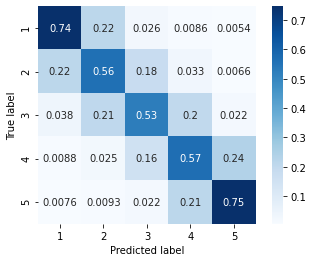


Testing Set
Accuracy: 0.658952

              precision    recall  f1-score   support

           0     0.7675    0.7444    0.7557     31175
           1     0.4480    0.5670    0.5005     22635
           2     0.4892    0.5274    0.5076     30996
           3     0.5437    0.5731    0.5580     62024
           4     0.8319    0.7444    0.7857    103170

    accuracy                         0.6590    250000
   macro avg     0.6161    0.6313    0.6215    250000
weighted avg     0.6751    0.6590    0.6652    250000



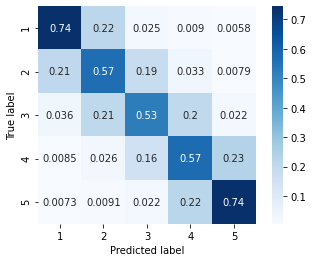

In [ ]:
evaluate_bert_model(model_bert_base_cased_64, model_name="bert_base_cased_64")

In [ ]:
del model_bert_base_cased_64

##### Uncased BERT

In [ ]:
model_bert_base_uncased = \
ClassificationModel('bert',
                    'bert-base-uncased',
                    num_labels=5,
                    args={"output_dir": "outputs_bert_base_uncased/",
                          "best_model_dir": "outputs_bert_base_uncased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": True,
                          "evaluate_during_training_steps": 5000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model_bert_base_uncased.train_model(df_train, eval_df=df_dev)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(78125,
 {'eval_loss': [0.8204066128315926,
   0.837067111922741,
   0.7913868771092891,
   0.7459764946963787,
   0.7419606607005597,
   0.7904490822882653,
   0.7685435373106003,
   0.7231323370263576,
   0.7590988210964202,
   0.7488109285311699,
   0.7114863122601509,
   0.7085428525056839,
   0.7320120221619606,
   0.7146307208821774,
   0.7086133158624173,
   0.7086647631006241],
  'global_step': [5000,
   10000,
   15000,
   20000,
   25000,
   30000,
   35000,
   40000,
   45000,
   50000,
   55000,
   60000,
   65000,
   70000,
   75000,
   78125],
  'mcc': [0.5166802492821114,
   0.5190024475613837,
   0.5369395815747035,
   0.5544542847043005,
   0.561105869326748,
   0.5393751007265953,
   0.5525886623853802,
   0.5730768368610523,
   0.555213957138477,
   0.5613620487545311,
   0.5811541110799181,
   0.5819638536860245,
   0.5711918986450403,
   0.5793662314029552,
   0.5821446233251802,
   0.5821652682553559],
  'train_loss': [1.0406605005264282,
   0.8545016646385193,
  

In [ ]:
model_bert_base_uncased = \
ClassificationModel('bert',
                    'outputs_bert_base_uncased/',
                    num_labels=5,
                    args={"output_dir": "outputs_bert_base_uncased/",
                          "best_model_dir": "outputs_bert_base_uncased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": True,
                          "evaluate_during_training_steps": 5000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})


Validation Set
Accuracy: 0.689792

              precision    recall  f1-score   support

           0     0.7892    0.7744    0.7818     31118
           1     0.5031    0.6015    0.5479     22851
           2     0.5496    0.5853    0.5669     31401
           3     0.5761    0.6161    0.5954     62178
           4     0.8450    0.7606    0.8005    102452

    accuracy                         0.6898    250000
   macro avg     0.6526    0.6676    0.6585    250000
weighted avg     0.7028    0.6898    0.6947    250000



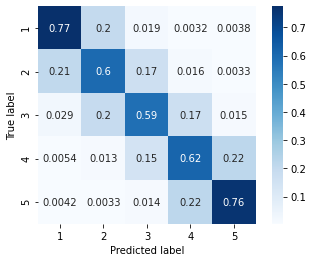


Testing Set
Accuracy: 0.691052

              precision    recall  f1-score   support

           0     0.7953    0.7747    0.7849     31175
           1     0.5046    0.6008    0.5485     22635
           2     0.5444    0.5853    0.5641     30996
           3     0.5746    0.6189    0.5959     62024
           4     0.8480    0.7607    0.8020    103170

    accuracy                         0.6911    250000
   macro avg     0.6534    0.6681    0.6591    250000
weighted avg     0.7049    0.6911    0.6963    250000



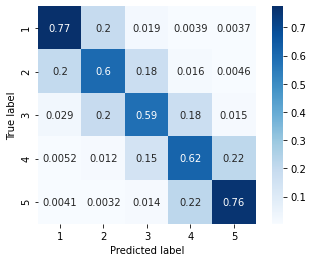

In [ ]:
evaluate_bert_model(model_bert_base_uncased, model_name="bert_base_uncased")

In [ ]:
del model_bert_base_uncased

##### Cased BERT

In [ ]:
model_bert_base_cased = \
ClassificationModel('bert',
                    'bert-base-cased',
                    num_labels=5,
                    args={"output_dir": "outputs_bert_base_cased/",
                          "best_model_dir": "outputs_bert_base_cased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
model_bert_base_cased.train_model(df_train)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(78125, 0.814038148649025)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5b6a693e48>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5b6a693e48>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Validation Set
Accuracy: 0.696088

              precision    recall  f1-score   support

           0     0.7869    0.7917    0.7893     31118
           1     0.5090    0.5889    0.5461     22851
           2     0.5495    0.6007    0.5740     31401
           3     0.5889    0.6017    0.5952     62178
           4     0.8438    0.7774    0.8093    102452

    accuracy                         0.6961    250000
   macro avg     0.6556    0.6721    0.6628    250000
weighted avg     0.7058    0.6961    0.6999    250000



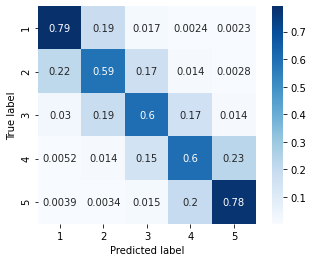


Testing Set
Accuracy: 0.69712

              precision    recall  f1-score   support

           0     0.7934    0.7907    0.7921     31175
           1     0.5108    0.5919    0.5484     22635
           2     0.5447    0.5989    0.5705     30996
           3     0.5865    0.6053    0.5958     62024
           4     0.8469    0.7766    0.8102    103170

    accuracy                         0.6971    250000
   macro avg     0.6565    0.6727    0.6634    250000
weighted avg     0.7077    0.6971    0.7013    250000



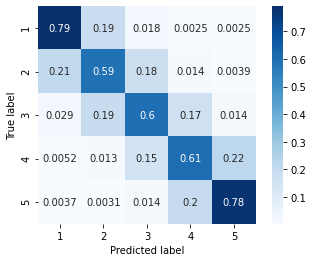

In [ ]:
evaluate_bert_model(model_bert_base_cased, model_name="bert_base_cased")

In [ ]:
del model_bert_base_cased

##### Cased Large BERT

In [ ]:
model_bert_large_cased = \
ClassificationModel('bert',
                    'bert-large-cased',
                    num_labels=5,
                    args={"output_dir": "outputs_bert_large_cased/",
                          "best_model_dir": "outputs_bert_large_cased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

In [ ]:
model_bert_large_cased.train_model(df_train)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(78125, 0.8128059037542343)


Validation Set
Accuracy: 0.699168

              precision    recall  f1-score   support

           0     0.7985    0.7782    0.7882     31118
           1     0.5111    0.6072    0.5550     22851
           2     0.5550    0.6029    0.5780     31401
           3     0.5916    0.6107    0.6010     62178
           4     0.8469    0.7788    0.8114    102452

    accuracy                         0.6992    250000
   macro avg     0.6606    0.6756    0.6667    250000
weighted avg     0.7100    0.6992    0.7034    250000



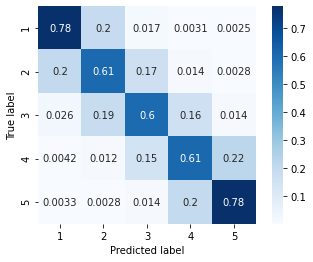


Testing Set
Accuracy: 0.700408

              precision    recall  f1-score   support

           0     0.8068    0.7799    0.7931     31175
           1     0.5136    0.6130    0.5589     22635
           2     0.5523    0.6039    0.5769     30996
           3     0.5889    0.6115    0.6000     62024
           4     0.8489    0.7780    0.8119    103170

    accuracy                         0.7004    250000
   macro avg     0.6621    0.6773    0.6682    250000
weighted avg     0.7120    0.7004    0.7050    250000



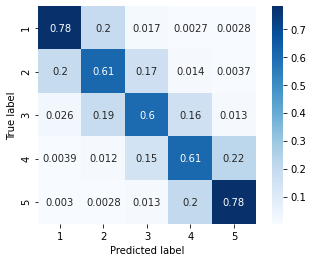

In [ ]:
evaluate_bert_model(model_bert_large_cased, model_name="bert_large_cased")

In [ ]:
del model_bert_large_cased

#### DistilBERT 

##### Uncased DistilBERT

In [ ]:
model_distilbert_base_uncased = \
ClassificationModel('distilbert', 
                    'distilbert-base-uncased', 
                    num_labels=5,
                    args={"output_dir": "outputs_distilbert_base_uncased/",
                          "best_model_dir": "outputs_distilbert_base_uncased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [ ]:
model_distilbert_base_uncased.train_model(df_train)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(78125, 0.8415822796463013)


Validation Set
Accuracy: 0.68422

              precision    recall  f1-score   support

           0     0.7881    0.7575    0.7725     31118
           1     0.4878    0.6017    0.5388     22851
           2     0.5389    0.5773    0.5574     31401
           3     0.5759    0.5950    0.5853     62178
           4     0.8360    0.7673    0.8002    102452

    accuracy                         0.6842    250000
   macro avg     0.6454    0.6598    0.6508    250000
weighted avg     0.6962    0.6842    0.6889    250000



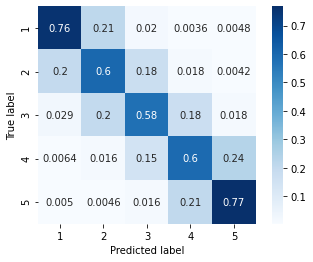


Testing Set
Accuracy: 0.68466

              precision    recall  f1-score   support

           0     0.7951    0.7568    0.7755     31175
           1     0.4888    0.6051    0.5408     22635
           2     0.5340    0.5760    0.5542     30996
           3     0.5726    0.5956    0.5839     62024
           4     0.8381    0.7665    0.8007    103170

    accuracy                         0.6847    250000
   macro avg     0.6457    0.6600    0.6510    250000
weighted avg     0.6975    0.6847    0.6897    250000



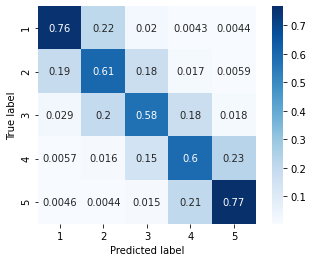

In [ ]:
evaluate_bert_model(model_distilbert_base_uncased, model_name="distilbert_base_uncased")

In [ ]:
del model_distilbert_base_uncased

##### Cased DistilBERT

In [ ]:
model_distilbert_base_cased = \
ClassificationModel('distilbert',
                    'distilbert-base-cased',
                    num_labels=5,
                    args={"output_dir": "outputs_distilbert_base_cased/",
                          "best_model_dir": "outputs_bert_distilbert_base_cased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier

In [ ]:
model_distilbert_base_cased.train_model(df_train)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(78125, 0.8240574915271759)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5b97525550>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5b97525550>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Validation Set
Accuracy: 0.693548

              precision    recall  f1-score   support

           0     0.7911    0.7779    0.7845     31118
           1     0.5015    0.5952    0.5444     22851
           2     0.5496    0.5836    0.5661     31401
           3     0.5868    0.5982    0.5924     62178
           4     0.8378    0.7814    0.8087    102452

    accuracy                         0.6935    250000
   macro avg     0.6534    0.6673    0.6592    250000
weighted avg     0.7026    0.6935    0.6972    250000



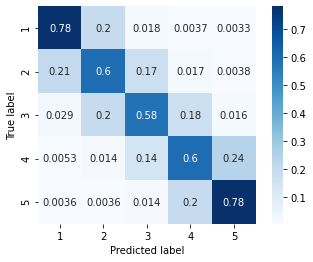


Testing Set
Accuracy: 0.694388

              precision    recall  f1-score   support

           0     0.7976    0.7749    0.7861     31175
           1     0.5027    0.5977    0.5461     22635
           2     0.5416    0.5838    0.5619     30996
           3     0.5854    0.5995    0.5924     62024
           4     0.8411    0.7815    0.8102    103170

    accuracy                         0.6944    250000
   macro avg     0.6537    0.6675    0.6593    250000
weighted avg     0.7045    0.6944    0.6985    250000



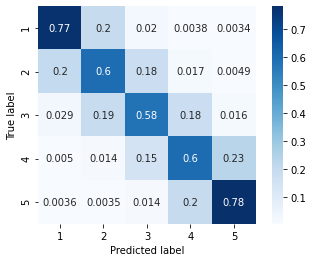

In [ ]:
evaluate_bert_model(model_distilbert_base_cased, model_name="distilbert_base_cased")

In [ ]:
del model_distilbert_base_cased

#### RoBERTa

In [ ]:
model_roberta_base = \
ClassificationModel('roberta', 
                    'roberta-base', 
                    num_labels=5,
                    args={"output_dir": "outputs_roberta_base/",
                          "best_model_dir": "outputs_roberta_base/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 10000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 10000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [ ]:
model_roberta_base.train_model(df_train)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(78125, 0.7975552875375748)


Validation Set
Accuracy: 0.701536

              precision    recall  f1-score   support

           0     0.8036    0.7844    0.7939     31118
           1     0.5135    0.6090    0.5572     22851
           2     0.5615    0.6082    0.5839     31401
           3     0.5911    0.6235    0.6069     62178
           4     0.8522    0.7730    0.8106    102452

    accuracy                         0.7015    250000
   macro avg     0.6644    0.6796    0.6705    250000
weighted avg     0.7137    0.7015    0.7062    250000



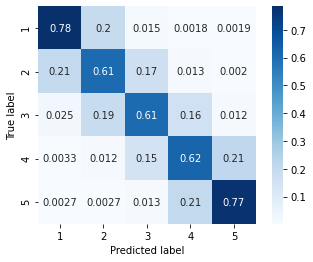


Testing Set
Accuracy: 0.702916

              precision    recall  f1-score   support

           0     0.8119    0.7818    0.7966     31175
           1     0.5143    0.6156    0.5604     22635
           2     0.5577    0.6062    0.5809     30996
           3     0.5900    0.6273    0.6081     62024
           4     0.8550    0.7727    0.8118    103170

    accuracy                         0.7029    250000
   macro avg     0.6658    0.6807    0.6716    250000
weighted avg     0.7162    0.7029    0.7080    250000



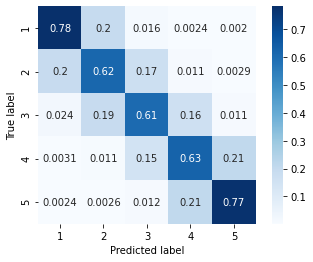

In [ ]:
evaluate_bert_model(model_roberta_base, model_name="roberta_base")

In [ ]:
del model_roberta_base

#### XLNet

In [ ]:
model_xlnet_base_cased = \
ClassificationModel('xlnet', 
                    'xlnet-base-cased', 
                    num_labels=5,
                    args={"output_dir": "outputs_xlnet_base_cased/",
                          "best_model_dir": "outputs_xlnet_base_cased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 10000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 10000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
model_xlnet_base_cased.train_model(df_train)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(78125, 0.7971919678201675)


Validation Set
Accuracy: 0.703548

              precision    recall  f1-score   support

           0     0.8015    0.7842    0.7928     31118
           1     0.5201    0.5948    0.5549     22851
           2     0.5595    0.6224    0.5893     31401
           3     0.5976    0.6123    0.6049     62178
           4     0.8470    0.7836    0.8140    102452

    accuracy                         0.7035    250000
   macro avg     0.6651    0.6795    0.6712    250000
weighted avg     0.7133    0.7035    0.7074    250000



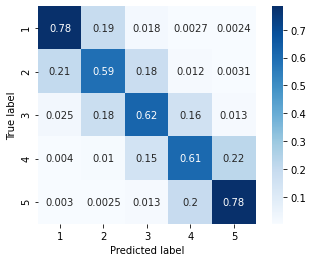


Testing Set
Accuracy: 0.704404

              precision    recall  f1-score   support

           0     0.8097    0.7816    0.7954     31175
           1     0.5231    0.6012    0.5594     22635
           2     0.5558    0.6228    0.5874     30996
           3     0.5943    0.6146    0.6043     62024
           4     0.8494    0.7822    0.8144    103170

    accuracy                         0.7044    250000
   macro avg     0.6664    0.6805    0.6722    250000
weighted avg     0.7152    0.7044    0.7087    250000



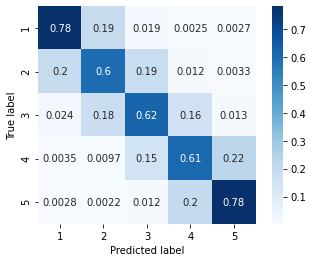

In [ ]:
evaluate_bert_model(model_xlnet_base_cased, model_name="xlnet_base_cased")

In [ ]:
del model_xlnet_base_cased

## Conclusions

In this project, Yelp review ratings are predicted through machine learning and transformer-based models.